In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
%matplotlib inline
np.random.seed(4)

from option import Option 
from process import GeometricBrownianMotion, HestonProcess
from pricing import monte_carlo_simulation, monte_carlo_simulation_LS, black_scholes_merton, crr_pricing

The option file contains class representing derivative options <br>
The process file contains class representing stocastic models <br>
The pricing file contains functions for pricing derivatives using different techniques

# Classic Monte Carlo

First let's use the GeometricBrownianMotion class to simulation some GBM paths. This class use the available closed form formula of the GBM stocastic process
$$ 
dS_t = \mu S_t dt +  \sigma S_t dW_t
$$
Using the solution of this SDE, we can use numpy vectorization to simulate the paths in an efficient way. This allow us to simulate a good number of paths quite rapidly

In [56]:
gmb = GeometricBrownianMotion(mu=0.05, sigma=0.2, s0=60)
gmb

GeometricBrownianMotion(mu=0.05, sigma=0.2, s0=60)

In [57]:
%time test = gmb.simulate(T=1, n=200_000, m=252)

Wall time: 4.83 s


Only 5 sec to generate 200k paths

Now we can display the results of the simulation. Let's plot 10 simulated GBM paths

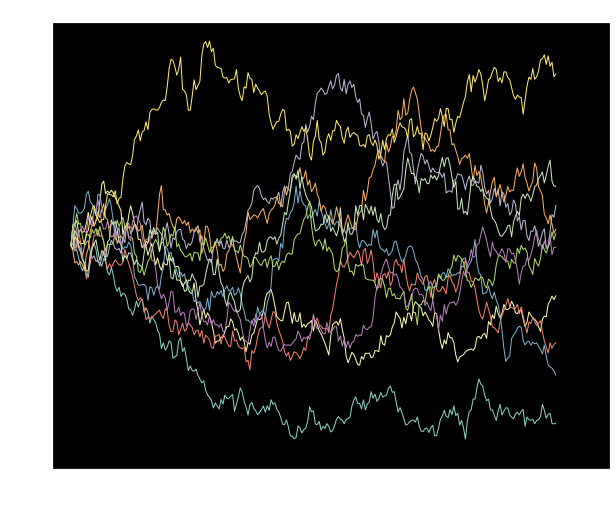

In [64]:
S = gmb.simulate(T=1, n=10, m=252)  # n = number of path, m = number of discretization points

plt.figure(figsize=(10, 8))
plt.plot(S)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$S_t$', fontsize=20, labelpad=20).set_rotation(0)
plt.title('Simulation of 10 GBM paths', fontsize=15)
plt.xlim(-10, 280)
plt.show()

Now we use the Option class to represente the parameters of an option derivative 

In [65]:
option = Option(T=1, K=80, call=True)
option

Option(T=1, K=80, call=True)

With both an option and a process representing the dynamic of the underlying, we can use the classic Monte Carlo method to approximate the price of the option. For this, we use the monte_carlo_simulation function from the custom princing module.

In [66]:
%time price = monte_carlo_simulation(option=option, process=gmb, n=200_000, m=252)

option = Option(T=1, K=80, call=False)
%time price = monte_carlo_simulation(option=option, process=gmb, n=200_000, m=252)

The price of Option(T=1, K=80, call=True) = 0.77
95.0% confidence interval = [0.76, 0.79]
Wall time: 4.69 s
The price of Option(T=1, K=80, call=False) = 16.86
95.0% confidence interval = [16.82, 16.91]
Wall time: 4.53 s


Now let's compare these results with the closed form formula of a vanilla call and put options when the underlying follows a GMB process. For this we use the black_scholes_merton function

In [67]:
call_price = black_scholes_merton(s0=60, K=80, T=1, r=0.05, sigma=0.2, call=True)
put_price = black_scholes_merton(s0=60, K=80, T=1, r=0.05, sigma=0.2, call=False)

print(f'Theorical price of the call option = {call_price}')
print(f'Theorical price of the put option = {put_price}')

Theorical price of the call option = 0.77
Theorical price of the put option = 16.87


Very close !

# Longstaff-Schwartz applied to the Heston model 

We will now try to estimate the price of an american option in the Heston framework:<br><br>

$$ 
\begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \eta \sqrt{v_t} dW^2_t \\
dW^1_t dW^2_t = \rho dt
\end{cases}
$$

<br>
Like for the GBM process, we use the HestonProcess class to simulte an Heston process numerically. The paths are simulated using the Milstein schema of discretization. As opposite to the first process, it is not possible to fully vectorize the calculation of the paths. Thus, the simulation takes much longer than for the GeometricBrownianMotion class.

In [2]:
heston = HestonProcess(mu=0.05, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5, s0=60, v0=0.05)
heston

HestonProcess(mu=0.05, kappa=0.0005, theta=0.04, eta=0.1, rho=-0.5, s0=60, v0=0.05)

In [3]:
%time s = heston.simulate(T=1, n=5_000, m=252)

Wall time: 9.14 s


More than 8 sec for 5k paths vs 5 sec for 200k with the GMB process

Then let's create two american put options

In [4]:
option1 = Option(T=1, K=40, call=False)    # From the original paper of Longstaff and Schwartz
option2 = Option(T=5/12, K=50, call=False) # From the Hull book

option1

Option(T=1, K=40, call=False)

Now we use the Longstaff-Schwartz algorithm to evaluate the price of the americain put options.<br><br>
The algorithm estimate the price of an americain option in a backward induction manner, just like in a CRR tree. We take discretization nodes = possible dates of exercise for the sake of simplicity. At each node of discretization, we fit a polynome (using the Polynome class from numpy) between the silumated paths and the discounted continuation value at the next step in time. Then the current continuation value is estimated using the parametres of the fitted polynome. <br><br>
For this implementation we use all the paths even though Longstaff and Schwartz pointed that using only the in-the-money paths is probably more efficient. The algorithm is implemented in the monte_carlo_simulation_LS function

In [5]:
%time monte_carlo_simulation_LS(option=option1, process=heston, n=25_000, m=252)
%time monte_carlo_simulation_LS(option=option2, process=heston, n=25_000, m=252)

The price of Option(T=1, K=40, call=False) = 0.1287
Wall time: 43 s
The price of Option(T=0.4166666666666667, K=50, call=False) = 0.3132
Wall time: 43.2 s


We can control the implementation of the monte_carlo_simulation_LS function by using an GBM process and comparing the results with a simple CRR tree. Like the Longstaff and Schwartz this algorithm this work in a backward manner. The CRR tree pricing method is implemented in the crr_pricing function.

In [6]:
option = Option(T=1, K=40, call=False)
gmb = GeometricBrownianMotion(mu=.06, sigma=.2, s0=36)

%time monte_carlo_simulation_LS(option=option, process=gmb, n=25_000, m=252)

The price of Option(T=1, K=40, call=False) = 4.4415
Wall time: 2.2 s


In [7]:
crr = crr_pricing(s0=36, K=40, T=1, r=.06, sigma=.2, n=25000)
print(f'The price of a put option estimated via a crr tree = {crr}')

The price of a put option estimated via a crr tree = 4.487
